# GRAPPA student seminar: Indirect detection - J-factors

by Paul Hofland, Bouke Jung and Iris de Ruiter

In [2]:
# Import all libraries
from __future__ import division
import numpy as np
import pylab as plt
import scipy.optimize as op
from scipy.integrate import odeint
from scipy.integrate import nquad
%matplotlib inline

In [3]:
# kpc in cm
kpc_to_cm = 3.086e+21

# The density profiles 

In [4]:
# Density profiles that return either the density (square=False) 
# or density squared (square=True)

def DM_density_NFW(r, rho_0, r_s, square=False):
    rho = rho_0 / ((r / r_s) * (1 + (r / r_s))**2 )
    if (square!=True):
        return rho
    else:
        return rho**2
    
def DM_density_BURK(r, rho_0, r_s, square=False):
    rho =  rho_0 / ((1 + r / r_s) * (1 + (r / r_s )**2))
    if (square!=True):
        return rho
    else:
        return rho**2
    
def DM_density_EIN(r, rho_0, r_s, a, square=False):
    rho = rho_0 * np.exp(-(2 / a) * ((r/r_s)**a - 1))
    if (square!=True):
        return rho
    else:
        return rho**2

def DM_density_GNFW(r, rho_0, r_s, gamma, square=False):
    rho = rho_0/((r/r_s)**gamma*(1+(r/r_s))**(3-gamma))
    if (square!=True):
        return rho
    else:
        return rho**2
    
    
# General DM density function, where TYPE represents the density profile
# rho_0 is the central density in GeV/cm^3, r_s is the scale radius in cm
# gamma plays a role in the GNFW profile,
# a plays a role in the Einasto profile and
# squared can be used to return either the density or the density squared
def DM_density(TYPE, r, rho_0, r_s, gamma=1, a=1, square=False):
    if ((TYPE=="NFW") or (TYPE=="nfw")):
        return DM_density_NFW(r, rho_0, r_s, square)
    elif ((TYPE=="Burk") or (TYPE=="Burkert") or (TYPE=="BURK")):
        return DM_density_BURK(r, rho_0, r_s, square)
    elif ((TYPE=="Ein") or (TYPE=="EIN") or (TYPE=="Einasto")):
        return DM_density_EIN(r, rho_0, r_s, a, square)
    elif ((TYPE=="GNFW") or (TYPE=="gnfw")):
        return DM_density_GNFW(r, rho_0, r_s, gamma, square)   
    else:
        print("Error: \tdensity profile TYPE was not recognized. Returned -1.")
        print("\tPlease specify either of the following profile TYPEs:")
        print("\t\t-\"NFW\" for Navarro-Frenk-White profile")
        print("\t\t-\"Burk\" for Burkert profile")
        print("\t\t-\"Ein\" for Einasto profile")
        print("\t\t-\"GNFW\" for generalized Navarro-Frenk-White profile")
        return -1
        
# Allows for computation of the dark matter density along the line of 
# sight. Parameters:
#     - l: the line of sight distance into the dark matter halo
#     - mu: the cosine of the viewing angle w.r.t. the galactic center
def DM_density_LOS(l, mu, d=8.5*kpc_to_cm, rho_0=0.471, r_s = 16*kpc_to_cm,
                   gamma=1, a=1, square=True, Type="NFW"):
    r = np.sqrt(l**2 + d**2 - 2*l*d*mu)
    return DM_density(Type, r, rho_0, r_s, gamma, a, square)      

# Plot of the density profiles 

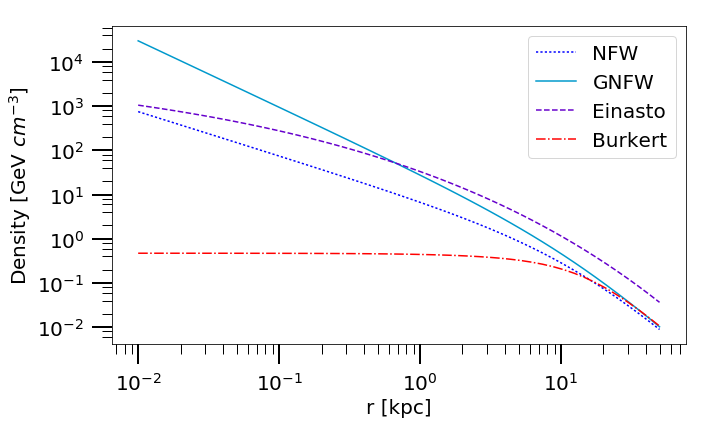

In [7]:
# Plot the density profiles for the Universe
rho_0=0.471 # GeV/cm^3
r_s=16*kpc_to_cm

#  Create a range of input radii and plot parameters
r=np.logspace(np.log10(0.01*kpc_to_cm), np.log10(50*kpc_to_cm), 50)
a_lst = [1,1,0.2,1]
gamma_lst = [1, 1.5, 1, 1]
typelst = ["NFW", "GNFW", "Einasto", "Burkert"]
colorlst = ["b","#0099cc", "#6600cc", 'r']
linestylelst = [":", "-", "--", "-."]

# Plot all density profiles
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for i in range(4):
    density = DM_density(typelst[i], r, rho_0, r_s, gamma_lst[i], a_lst[i])
    ax.plot(r/kpc_to_cm, density, color=colorlst[i], 
            linestyle=linestylelst[i], label=typelst[i])
ax.set_xlabel(r"r [kpc]", fontsize=20)
ax.set_ylabel(r"Density [GeV $cm^{-3}}$]", fontsize=20)
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_title("Compton scattered spectrum $E_{photon,in}=$"+str(e_in))
ax.tick_params('both', labelsize=20, length=20, width=2, which='major', pad=8)
ax.tick_params('both', labelsize=20, length=10, width=1, which='minor',pad=8)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

# J-factors for dwarf galaxies and galaxy clusters

Draco
MilkyWay


C:\Users\Iris\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
C:\Users\Iris\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


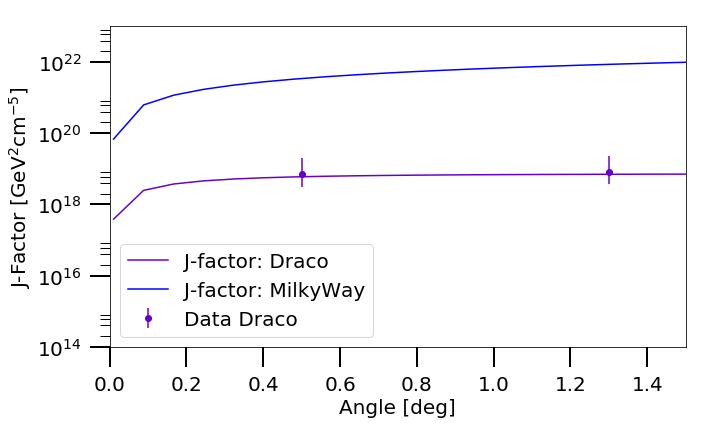

In [63]:
# data.txt is a txt file that contains all data for the dwarf galaxies

def plot_dwarf_galaxies(d_factor, objects, profile_type, max_angle, nof_evals):
    """Plots the J-factor and/or D-factor for the wanted objects."""
    # d_facor can be True or False, to specify whether or not it should be calculated.
    # objects is a list of object names that should be considered.
    # profile_type specifies the wanted density profile.
    # max_angle is the angle up to which the J-factor is calculated/plotted.
    # nof_evals defines at how many angles the J-factor should be calculated.
    
    # Initialize plot 
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_yscale("log")
    
    # Compute the J-factors
    angle = np.linspace(0.01, max_angle, nof_evals) # deg
    D_factors, J_factors = np.zeros([2, 5, nof_evals])
    
    # For each object, plot the data (if available) and 
    # calculate the J-factor at the wanted angles
    for obj_name in objects:
        print(obj_name)
        # Read in data file with all paramters needed
        with open("data.txt") as f:
            for line in f:
                if line.startswith(obj_name):
                    obj = line.split()
                    rho_0 = float(obj[1])
                    r_s = float(obj[2])*kpc_to_cm
                    d = float(obj[3])*kpc_to_cm
                    data_angle = np.array([float(obj[4]), float(obj[5])])
                    data_j = np.array([float(obj[6]), float(obj[7])])
                    data_j_upper_error = np.array([float(obj[8]), float(obj[9])])
                    data_j_lower_error = np.array([float(obj[10]), float(obj[11])])
                    plot_color=obj[12]
        ylower = 10**(data_j - data_j_lower_error)
        yupper = 10**(data_j + data_j_upper_error)
        
        # If all parameters are properly initialized, plot the data 
        if data_angle[0]!=0:
            ax.errorbar(data_angle, 10**data_j, yerr=[ylower, yupper], c=plot_color, label="Data "+obj_name, fmt="o")
        
        # Calculate the J-factor at each angle, using the nquad function with a relaxed stepsize
        for j, theta in enumerate(angle):
            theta *= (np.pi / 180) # Conversion to rad
            
            # Also calculate the D-factor is d_factor==True
            if d_factor==True:
                D = nquad(DM_density_LOS, [[0,2*d],[np.cos(theta),1]],
                                args=(d, rho_0, r_s, 1, 1, False, profile_type), epsrel=1e-3, opts={"epsrel":1e-3})
                D_factors[i,j] = 2*np.pi * D[0]
            
            J = nquad(DM_density_LOS, [[0,2*d],[np.cos(theta),1]],
                            args=(d, rho_0, r_s, 1, 1, True, profile_type),  opts={"epsrel":1e-3})
            J_factors[i,j] = 2*np.pi * J[0]
        
        # Plot the D-factor simulation results
        if d_factor==True:
            ax.plot(angle, D_factors[i], color=plot_color, linestyle="--", label="D-factor: "+ obj_name)
        
        # Plot the J-factor simulation
        ax.plot(angle, J_factors[i], color=plot_color, linestyle='-', label="J-factor: "+ obj_name)

    ax.set_xlabel("Angle [deg]", fontsize=20)
    ax.set_ylabel(r"J-Factor [$\mathrm{GeV}^2 \mathrm{cm}^{-5}$]", fontsize=20)
    ax.set_ylim([float(10**14), float(10**23)])
    ax.set_xlim([0,max_angle])
    ax.tick_params('both', labelsize=20, length=20, width=2, which='major', pad=8)
    ax.tick_params('both', labelsize=20, length=10, width=1, which='minor',pad=8)
    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.show()

#objects=["Milky Way", "Carina", "Draco", "LeoII"]
plot_dwarf_galaxies(d_factor=False, objects=["Draco", "MilkyWay"], profile_type="NFW", max_angle=1.5, nof_evals=20)